In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import decoupler as dc
import matplotlib.pyplot as plt

# Let's use decoupler for some fancy enrichment analyses

decoupler is a nifty, relatively recent package for both R and python. Let's load our saved anndata from `'../results/stjude_clustered.h5ad'` and run some nice stuff on it! 

## Automated PCA ~ metadata analysis

First, there is a nice, automated way to check for any association between metadata variables and principal components. Always checking this anyway, but `dc.tl.rankby_obsm` does it automatically for everything in `.obs` (be careful, it breaks if categorical columns have only one value). There is a corresponding plotting function `dc.pl.obsm()` which accepts a list of relevant `.obs` columns as `names=[...]`.

In [28]:

#ad_pns = sc.read_h5ad('../results/stjude_pns.h5ad')

In [29]:

ad = sc.read_h5ad('../results/stjude_clustered.h5ad')

In [30]:

ad.obs['sj_diseases'] = pd.Categorical(ad.obs['sj_diseases'])

In [31]:

dc.tl.rankby_obsm(ad, key="X_pca", uns_key="pca_assoc")

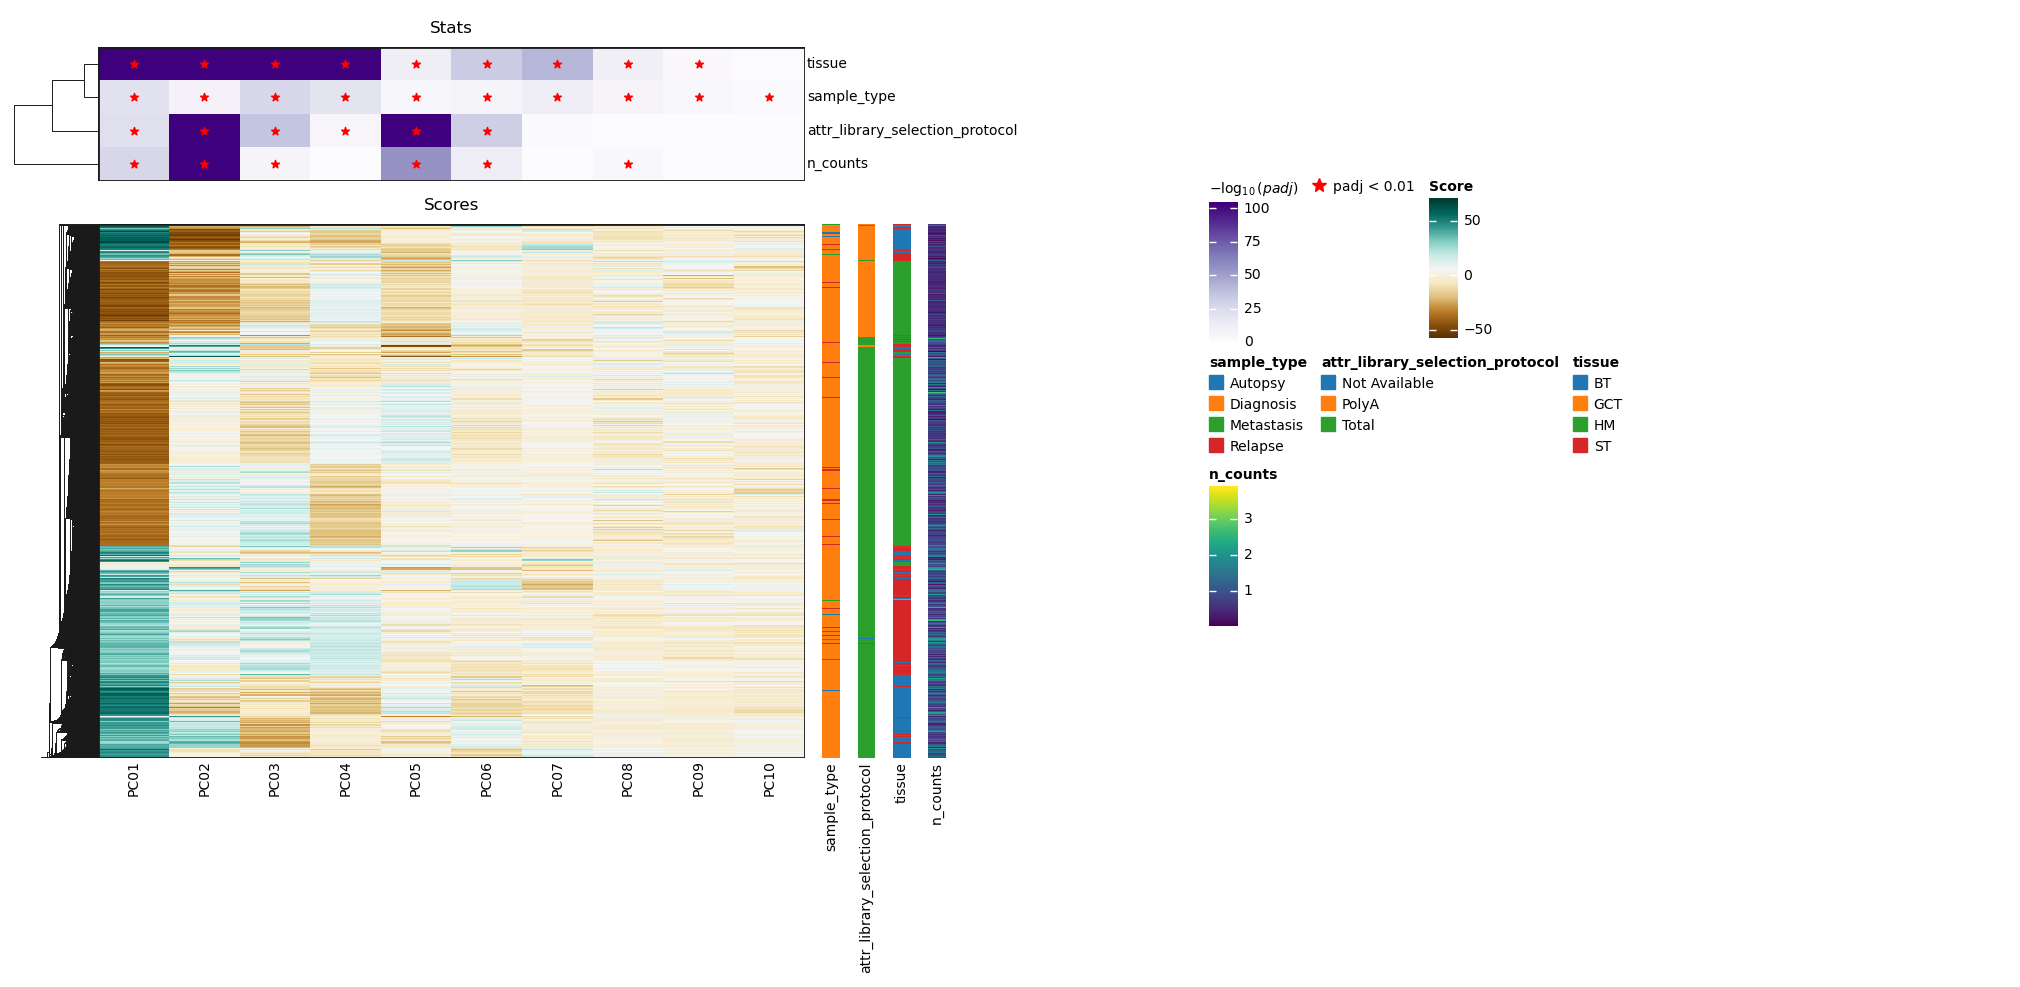

In [32]:

dc.pl.obsm(
    ad,
    key="pca_assoc",                    # same uns_key as above
    names=['sample_type', 'attr_library_selection_protocol', 'tissue', 'n_counts'],
    nvar=10,                            # first 10 PCs
    thr_sign=0.01,                      # significance threshold for padj
    figsize=(20,8)
)

## Cell type scoring

This one's a bit odd for bulk samples, but we can use decoupler's OmniPath module to retrieve a bunch of "lists of genes" (aka "resources"). Point in case is the growing catalog of cell-type markers in a resource called 'PangloaDB'.

In [33]:

# from https://decoupler.readthedocs.io/en/stable/notebooks/scell/rna_sc.html
markers = dc.op.resource("PanglaoDB", organism="human")
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
,,,,,,,,,,,,,
0,A1CF,False,Hepatocytes,Endoderm,True,0.189189,0.004437,True,0.175000,0.000257,9606,Liver,0.002
1,A2APA5,False,Germ cells,Mesoderm,False,0.000000,0.000000,True,0.432927,0.000000,10090,Reproductive,0.004
2,A2M,True,Bergmann glia,Ectoderm,True,0.000000,0.062343,True,0.333333,0.001604,9606,Brain,0.012
3,A3FIN4,False,Mast cells,Mesoderm,False,0.000000,0.000000,True,0.184211,0.000708,10090,Immune system,0.001
4,A4GALT,True,Mast cells,Mesoderm,True,0.000000,0.014133,True,0.000000,0.003023,9606,Immune system,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8206,ZNF521,False,Adipocyte progenitor cells,Mesoderm,True,0.000000,0.010338,False,0.000000,0.000000,9606,Connective tissue,0.002
8207,ZNRF4,False,Germ cells,Mesoderm,True,0.284360,0.000000,True,0.000000,0.000000,9606,Reproductive,0.010
8208,ZPBP2,True,Germ cells,Mesoderm,True,0.436019,0.000000,True,0.000000,0.000000,9606,Reproductive,0.008


There is some pre-processing left for us, which is 1) `drop_duplicates()` of entries with the same combination of `cell_type` and `genesymbol` and 2) turn the thing into a dataframe with `source` and `target` columns. `source` being the label we are after (here, `cell_type` in the original table) and `target` being a gene (hint: `df.rename(columns={...})`). This is the simplest form of what decoupler calls a `net`. We'll encounter a more advanced version soon.

In [34]:

# Remove duplicated entries
markers = markers.drop_duplicates(subset=["cell_type", "genesymbol"])

# Format
markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]
markers

,source,target
,,
0,Hepatocytes,A1CF
1,Germ cells,A2APA5
2,Bergmann glia,A2M
3,Mast cells,A3FIN4
4,Mast cells,A4GALT
...,...,...
8206,Adipocyte progenitor cells,ZNF521
8207,Germ cells,ZNRF4
8208,Germ cells,ZPBP2


There are many ways to score transcriptomes against lists of genes. (AUCells, GSEA, hypergeometric test, *etc.*). The authors of decoupler prefer a linear model, where a `net` is fitted to gene expression or differences upon perturbation, or whatever else you need and a high score means a good fit! Since we are trying to assign cell types here, let's try to match the gene expression profile using `dc.mt.ulm()`

In [35]:

dc.mt.ulm(data=ad, net=markers, tmin=3)

This creates a new entry under `.obsm` called `score_ulm` and it has as cell types as columns, and samples as rows. Elegantly, this again fits into the framework of the anndata object nicely! To get an adata object with cell type scores instead of genes as `.var_names`, we can use `dc.pp.get_obsm()`

In [36]:

ad.obsm["score_ulm"]

,Acinar cells,Adipocyte progenitor cells,Adipocytes,Adrenergic neurons,Airway epithelial cells,Airway goblet cells,Airway smooth muscle cells,Alpha cells,Alveolar macrophages,Anterior pituitary gland cells,...,Thymocytes,Transient cells,Trichocytes,Trigeminal neurons,Trophoblast cells,Trophoblast progenitor cells,Tuft cells,Undefined placental cells,Urothelial cells,Vascular smooth muscle cells
SJACT030424_D1,-2.445062,1.218159,6.036857,-0.271272,0.293105,0.886922,1.075554,0.904650,1.955863,1.695281,...,0.883077,5.186722,-0.922626,4.187458,1.560800,0.733654,2.450979,0.280690,-0.520268,5.684831
SJACT030437_D1,-2.133610,0.582661,6.986333,-0.640366,0.399760,1.952869,1.395467,-0.077091,3.760701,2.787584,...,1.510859,5.673259,-0.657274,4.221963,2.334221,0.713833,2.111630,0.409540,-0.920605,2.911591
SJACT030487_D1,-1.650417,0.295668,4.794539,0.072330,-1.037190,-1.073074,-0.152417,-1.001080,3.667749,0.956608,...,0.514751,4.544745,-1.632305,0.961067,2.014673,0.160771,2.035611,0.632595,-1.109138,1.315565
SJALCL031066_D1,-3.498853,-1.261758,2.966792,-0.517488,-0.010089,-1.437940,-0.482742,-1.573351,2.823188,-0.178368,...,3.899069,2.877078,-0.071066,1.313199,0.536757,-0.010240,1.589264,0.823017,-0.979612,1.476143
SJAML030210_D2,-1.043794,0.147972,5.069429,-0.395400,0.791292,8.172677,0.110608,-0.706852,3.452501,1.044372,...,2.638159,3.337098,-0.981803,0.526251,0.675081,0.210470,3.622212,1.151694,-0.429963,2.084538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SJAML074195_D1,-3.126948,-1.737502,-0.097622,-1.216085,-1.275669,-0.723347,-0.742392,-2.313423,1.824478,0.179246,...,1.932883,2.184266,-0.787249,0.491137,-0.561190,1.222072,1.399047,-0.412892,-1.295109,0.420305
SJAML074196_D1,-3.462685,-0.227859,0.063544,-0.945757,-1.153153,-1.086837,0.541827,-2.377249,0.975073,0.481724,...,2.520204,1.628500,-1.220996,-0.352910,-0.963226,0.484033,1.785242,-0.245257,0.451736,-0.702990
SJAML074197_D2,-1.874795,-0.518946,2.786131,0.579364,-0.388397,0.247674,-1.013297,-0.589833,4.446921,0.770015,...,3.696053,1.552942,-0.971764,2.371339,-0.336534,-0.122953,3.725881,-0.069799,1.605503,0.256729
SJMLL001_D,-3.080780,-0.508551,-0.974079,-0.652722,-0.860202,-0.365669,-0.078444,-2.488211,2.170407,0.431777,...,2.436884,2.276751,-1.524534,0.509915,-0.146143,0.873279,3.361427,-0.024878,0.064678,-1.059699


In [37]:

score = dc.pp.get_obsm(ad, key="score_ulm")
score

AnnData object with n_obs × n_vars = 5292 × 174
    obs: 'n_counts', 'log10_counts', 'sample_type', 'sj_diseases', 'sj_disease_hierarchy_code', 'sj_disease_hierarchy_name', 'attr_library_selection_protocol', 'tissue', 'system', 'tumor', 'leiden'
    uns: 'attr_library_selection_protocol_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_type_colors', 'system_colors', 'tissue_colors', 'umap', 'pca_assoc'
    obsm: 'X_pca', 'X_umap', 'score_ulm', 'padj_ulm'

In [38]:
sorted(score.var_names)

['Acinar cells',
 'Adipocyte progenitor cells',
 'Adipocytes',
 'Adrenergic neurons',
 'Airway epithelial cells',
 'Airway goblet cells',
 'Airway smooth muscle cells',
 'Alpha cells',
 'Alveolar macrophages',
 'Anterior pituitary gland cells',
 'Astrocytes',
 'B cells',
 'B cells memory',
 'B cells naive',
 'Basal cells',
 'Basophils',
 'Bergmann glia',
 'Beta cells',
 'Cajal-Retzius cells',
 'Cardiac stem and precursor cells',
 'Cardiomyocytes',
 'Cholangiocytes',
 'Cholinergic neurons',
 'Chondrocytes',
 'Choroid plexus cells',
 'Chromaffin cells',
 'Ciliated cells',
 'Clara cells',
 'Crypt cells',
 'Decidual cells',
 'Delta cells',
 'Dendritic cells',
 'Distal tubule cells',
 'Dopaminergic neurons',
 'Ductal cells',
 'Embryonic stem cells',
 'Endothelial cells',
 'Endothelial cells (aorta)',
 'Endothelial cells (blood brain barrier)',
 'Enteric glia cells',
 'Enteric neurons',
 'Enterochromaffin cells',
 'Enterocytes',
 'Enteroendocrine cells',
 'Eosinophils',
 'Ependymal cells',
 

## Getting an overview of cell-type scores and tumor types on a UMAP

Let's look at a few interesting cell type scores for us neuroblastomies: `["Neurons", "Schwann cells", 'Chromaffin cells', 'Neuroblasts', 'Noradrenergic neurons', "Radial glia cells", "Astrocytes", "Oligodendrocyte progenitor cells"]`

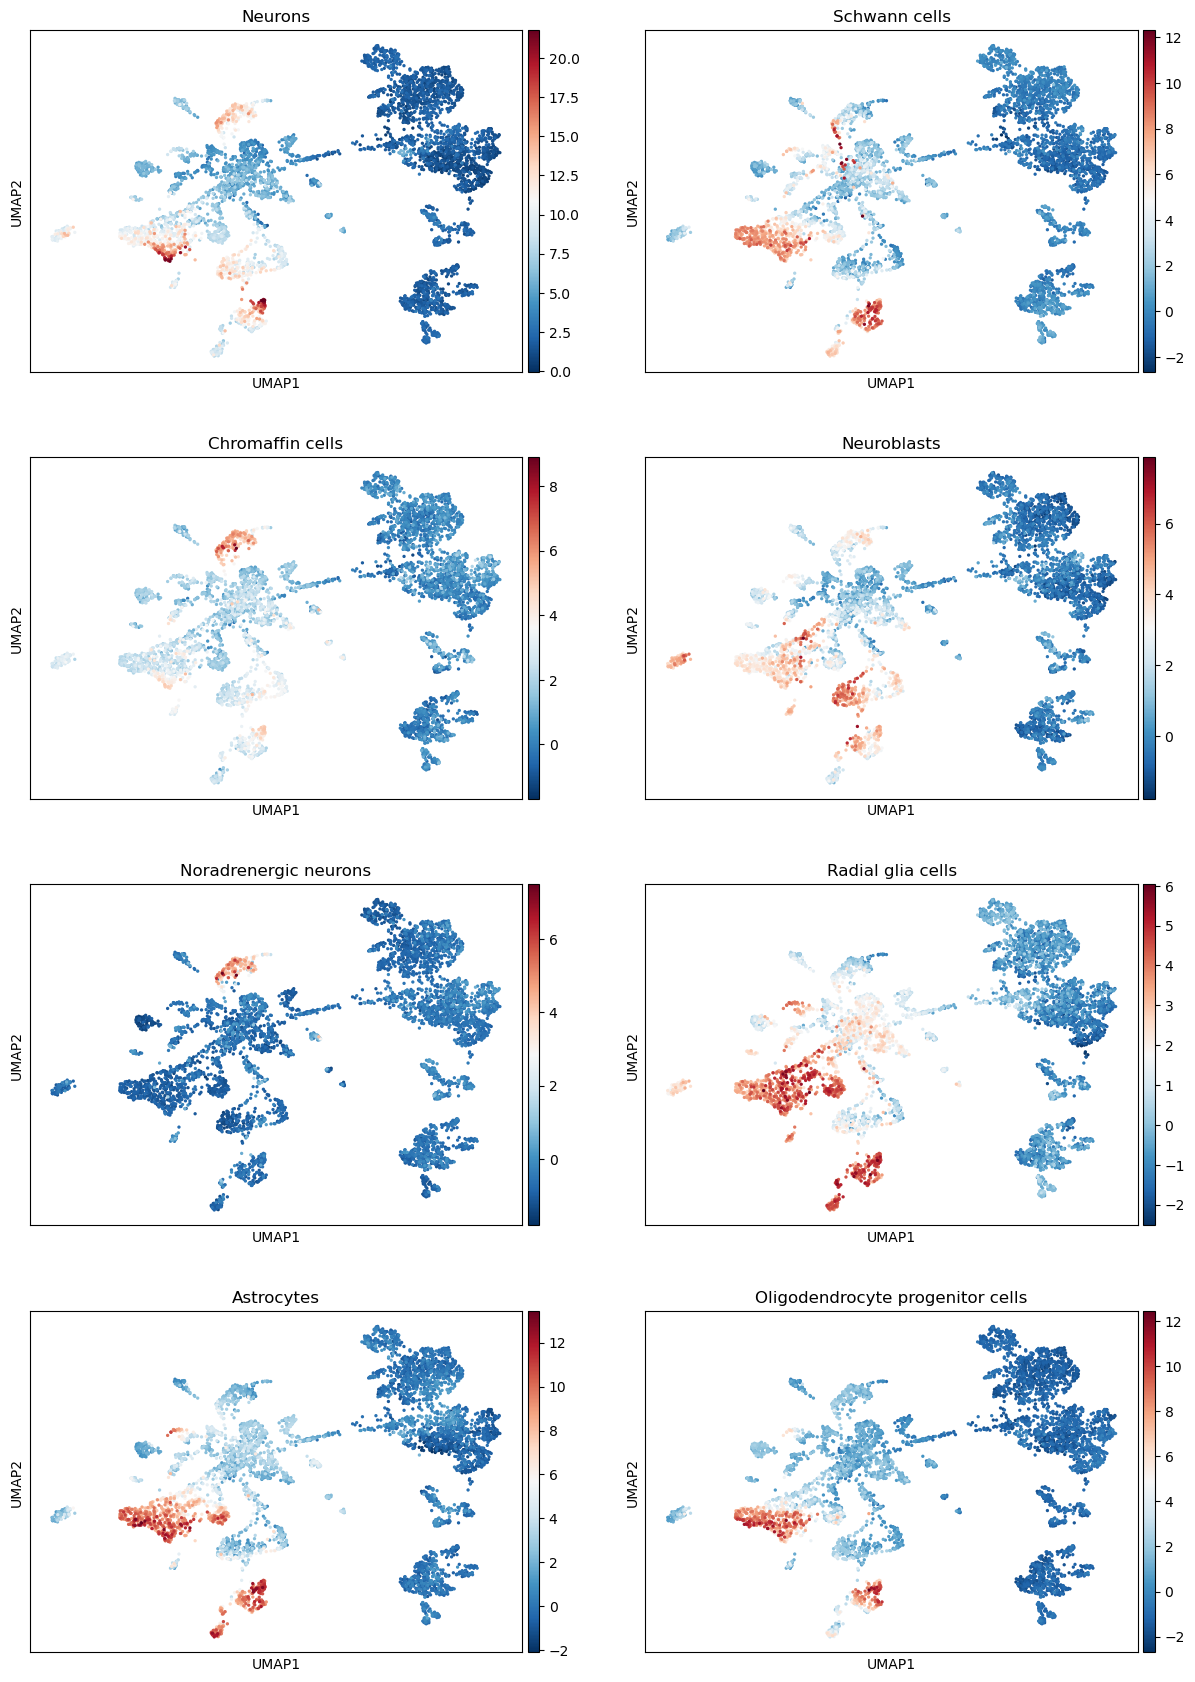

In [44]:

sc.pl.umap(score, color=["Neurons", "Schwann cells", 'Chromaffin cells', 'Neuroblasts', 'Noradrenergic neurons', "Radial glia cells", "Astrocytes", "Oligodendrocyte progenitor cells"], cmap="RdBu_r", ncols=2)

/opt/micromamba/envs/crc1588-sc-atlas/lib/python3.13/site-packages/scanpy/plotting/_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


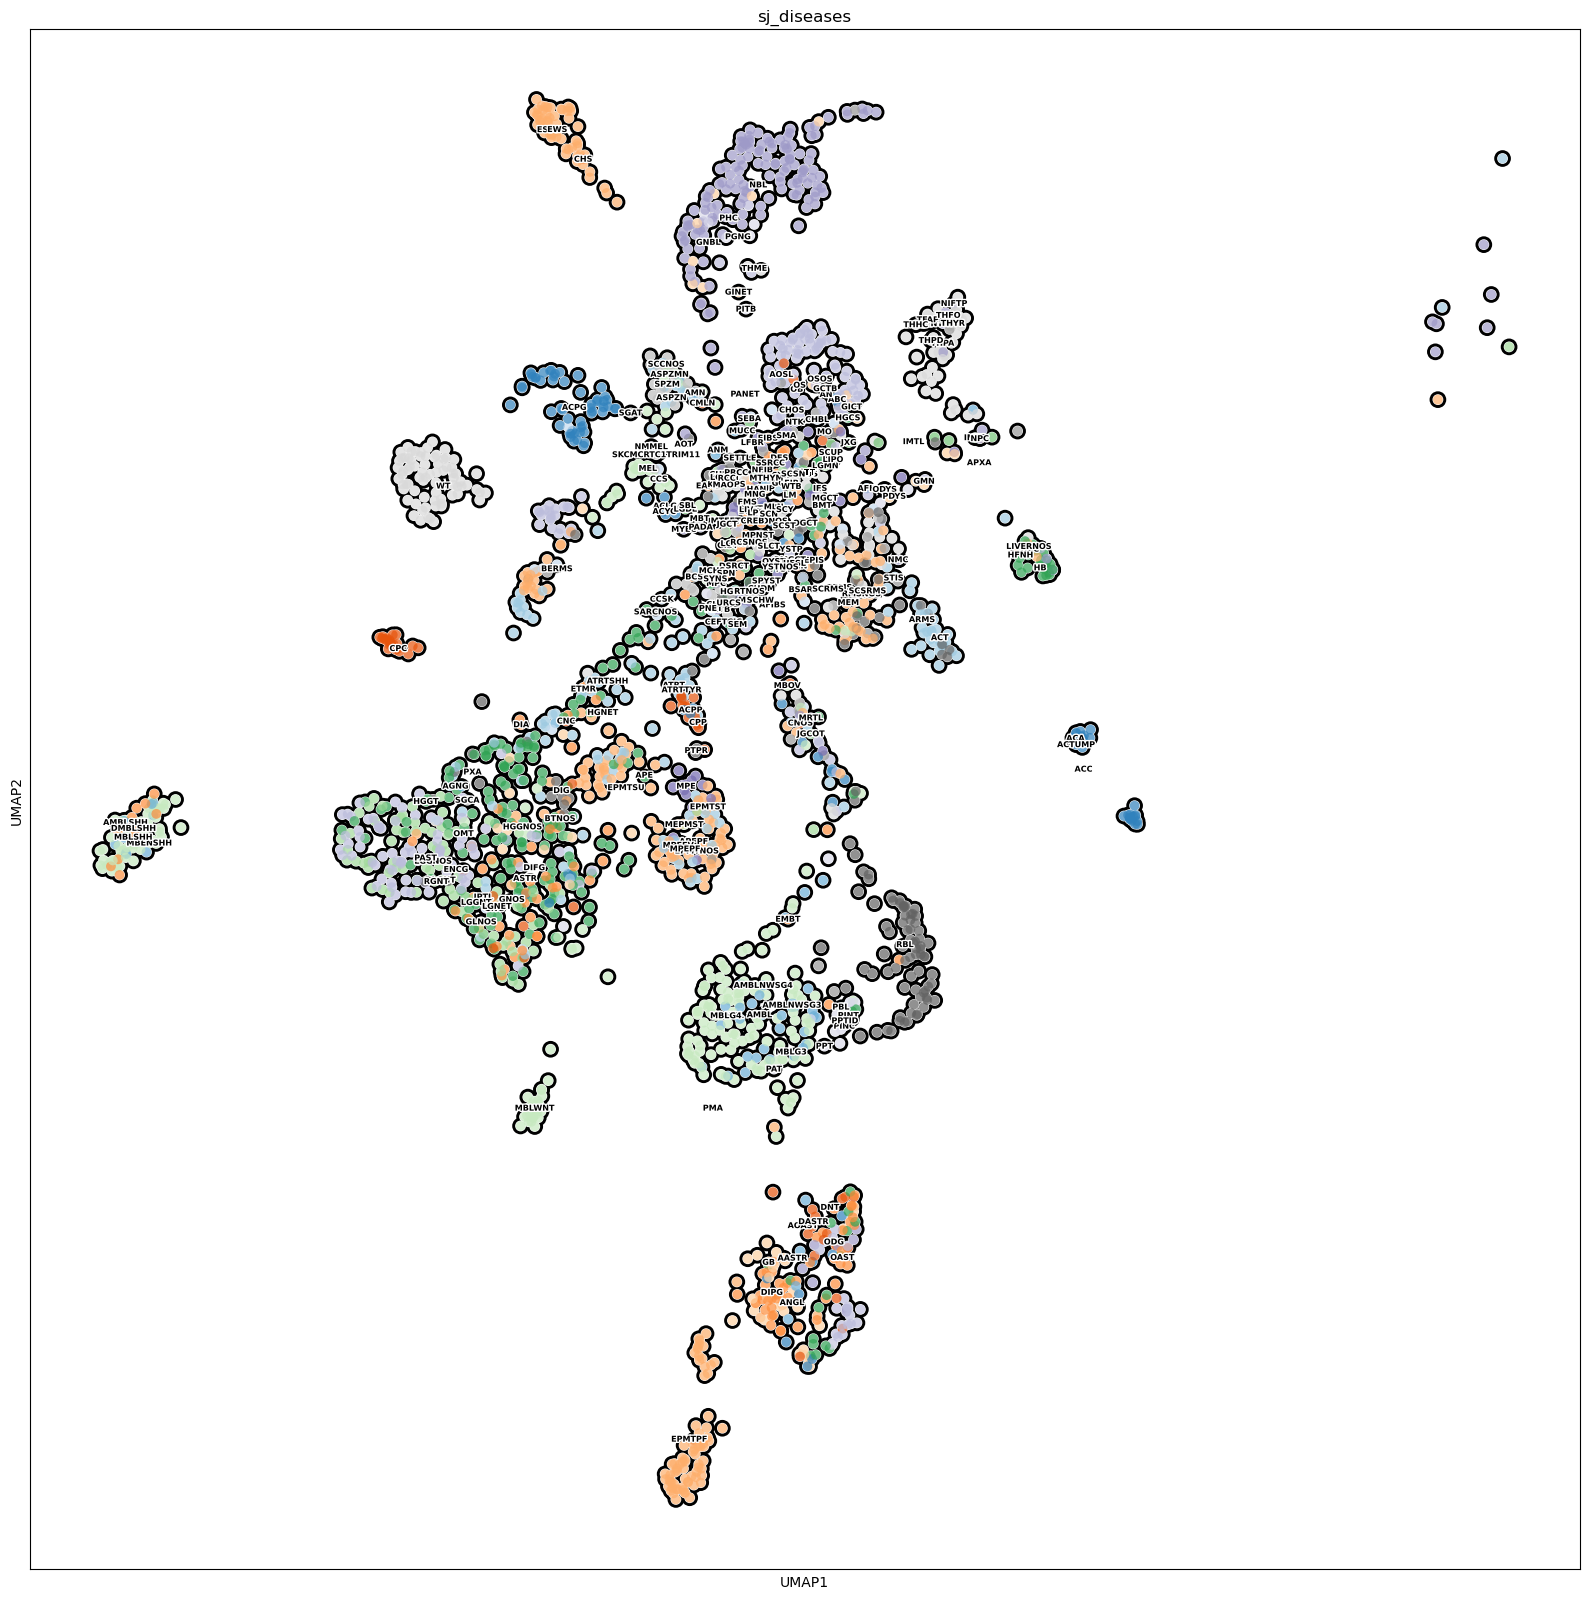

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(ad[ad.obs['tissue'] != 'HM'], color=["sj_diseases"], legend_loc="on data", legend_fontoutline=2, add_outline=True, size=200, legend_fontsize="xx-small", ax=ax, palette='tab20c')

In [40]:
tumor_lkup = ad.obs[['sj_diseases', 'tumor']].set_index('sj_diseases').to_dict()['tumor']

In [49]:
tumor_lkup['PHC']

'Pheochromocytoma'

## Inference of transcription factor activity 

Here's where the `net` can shine! It is long known that many TFs can activate some targets and repress others. The decoupler nets can utilize a `weight` column with positive or negative numbers to account for that. This very neatly fits into the linear model they use to score nets against... everything, really. Let's use the `collectri` resource from `dc.op`. We will find it already perfectly formatted and ready to go into `dc.mt.ulm`.

In [53]:

collectri = dc.op.collectri(organism="human")
collectri

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


In [55]:

dc.mt.ulm(data=ad, net=collectri)

In [57]:

score = dc.pp.get_obsm(adata=ad, key='score_ulm')
score

AnnData object with n_obs × n_vars = 5292 × 764
    obs: 'n_counts', 'log10_counts', 'sample_type', 'sj_diseases', 'sj_disease_hierarchy_code', 'sj_disease_hierarchy_name', 'attr_library_selection_protocol', 'tissue', 'system', 'tumor', 'leiden', 'approx'
    uns: 'attr_library_selection_protocol_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_type_colors', 'system_colors', 'tissue_colors', 'umap', 'pca_assoc', 'sj_diseases_colors'
    obsm: 'X_pca', 'X_umap', 'score_ulm', 'padj_ulm'

let's exclude the hematological malignancies (`'tissue' == 'HM'`) for now and focus on TF scores of the remaining samples. We want to identify marker TFs by using `dc.tl.rankby_group` using `method='t-test_overestim_var'`. and `reference='rest'`. Conveniently, this function already returns a dataframe, from we we can identify positive markers by selecting rows with `"stat" > 0`.

In [58]:

sscore = score[ad.obs['tissue'] != 'HM'].copy()

In [59]:

# identify marker TFs for each leiden cluster
df = dc.tl.rankby_group(adata=sscore, groupby="leiden", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]
df

/opt/micromamba/envs/crc1588-sc-atlas/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/micromamba/envs/crc1588-sc-atlas/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,group,reference,name,stat,meanchange,pval,padj
1,0,rest,GBX2,7.415797,1.033916,2.901611e-11,1.108415e-08
2,0,rest,LMX1B,7.239270,1.649033,1.022928e-10,2.605057e-08
3,0,rest,PBX1,7.065556,1.287484,2.154348e-10,3.795725e-08
4,0,rest,CREB3L1,7.305717,1.568715,2.484113e-10,3.795725e-08
5,0,rest,EMX2,6.968121,0.894405,3.082158e-10,3.924614e-08
...,...,...,...,...,...,...,...
32843,12,rest,MTA3,0.025019,0.009465,9.840685e-01,9.939376e-01
32846,12,rest,KLF13,0.016516,0.007102,9.883299e-01,9.939376e-01
32847,12,rest,GLI3,0.017641,0.012202,9.887337e-01,9.939376e-01
32850,12,rest,THRB,0.004046,0.002262,9.974156e-01,9.987228e-01


with some creative chaining of `groupby('group') drop_duplicates("name")` and friends, we can extract a list of top 3 TFs for each Leiden cluster in our data-set in the shape of a dictionary.

In [76]:

#The top 3 TF markers per cell type can then be extracted.
n_markers = 3
source_markers = (
    df.sort_values('stat', ascending=False)
    .groupby("group")
    .head(n_markers)
#    .drop_duplicates("name")
    .groupby("group")["name"]
    .apply(lambda x: list(x))
    .to_dict()
)
source_markers

{'0': ['GBX2', 'CREB3L1', 'LMX1B'],
 '1': ['SF1', 'NR5A1', 'NR5A2'],
 '12': ['CEBPE', 'GATA1', 'ZFPM1'],
 '13': ['GATA1', 'KLF1', 'ZFPM1'],
 '2': ['HOXC13', 'NFX1', 'VHL'],
 '25': [],
 '26': ['DLX1', 'MYT1', 'NKX6-2'],
 '27': ['NR2E1', 'ID4', 'OVOL1'],
 '28': ['IRX4', 'NR2E1', 'HOXC6'],
 '29': ['MYF5', 'PAX7', 'MYOG'],
 '3': ['IKZF1', 'STAT4', 'NOTO'],
 '30': ['SOX3', 'PRRX1', 'POU3F2'],
 '31': ['BARX2', 'HAND2', 'PHOX2B'],
 '32': ['WWTR1', 'ZKSCAN7', 'SMARCA5'],
 '33': ['RB1', 'FOXI1', 'FOXF1'],
 '34': ['GLI2', 'SOX4', 'POU3F1'],
 '35': ['ATOH7', 'LHX4', 'OTX2'],
 '36': ['OTX2', 'FOXN4', 'CRX'],
 '37': ['OVOL1', 'NR2E1', 'ID2'],
 '38': ['GRHL3', 'DLX4', 'MEIS2'],
 '39': ['FEZF1', 'NKX3-2', 'SIX3'],
 '40': ['RUNX2', 'SP7', 'ARID4A'],
 '41': ['ETS1', 'MYB', 'DNMT1'],
 '42': ['TBR1', 'LHX4', 'NEUROG2'],
 '43': ['MSX2', 'FOXJ1', 'PRDM16'],
 '44': ['FOXJ1', 'TCF7L1', 'RFX2'],
 '45': ['UBTF', 'EWSR1', 'MESP2'],
 '47': ['ATOH1', 'ATOH7', 'NPAS4'],
 '48': ['MESP2', 'HINFP', 'HOXA13'],
 '49': 

In [77]:

sc.tl.dendrogram(sscore, 'leiden')

In [78]:

approx_d = ad.obs[['leiden', 'tumor']].groupby('leiden').apply(lambda x: x['tumor'].value_counts().index[0]).to_dict()
ad.obs['approx'] = ad.obs['leiden'].apply(lambda x: approx_d.get(x, x))

categories: Acute Myeloid Leukemia, Adrenocortical Carcinoma, Alveolar Rhabdomyosarcoma, etc.
var_group_labels: 0, 1, 12, etc.


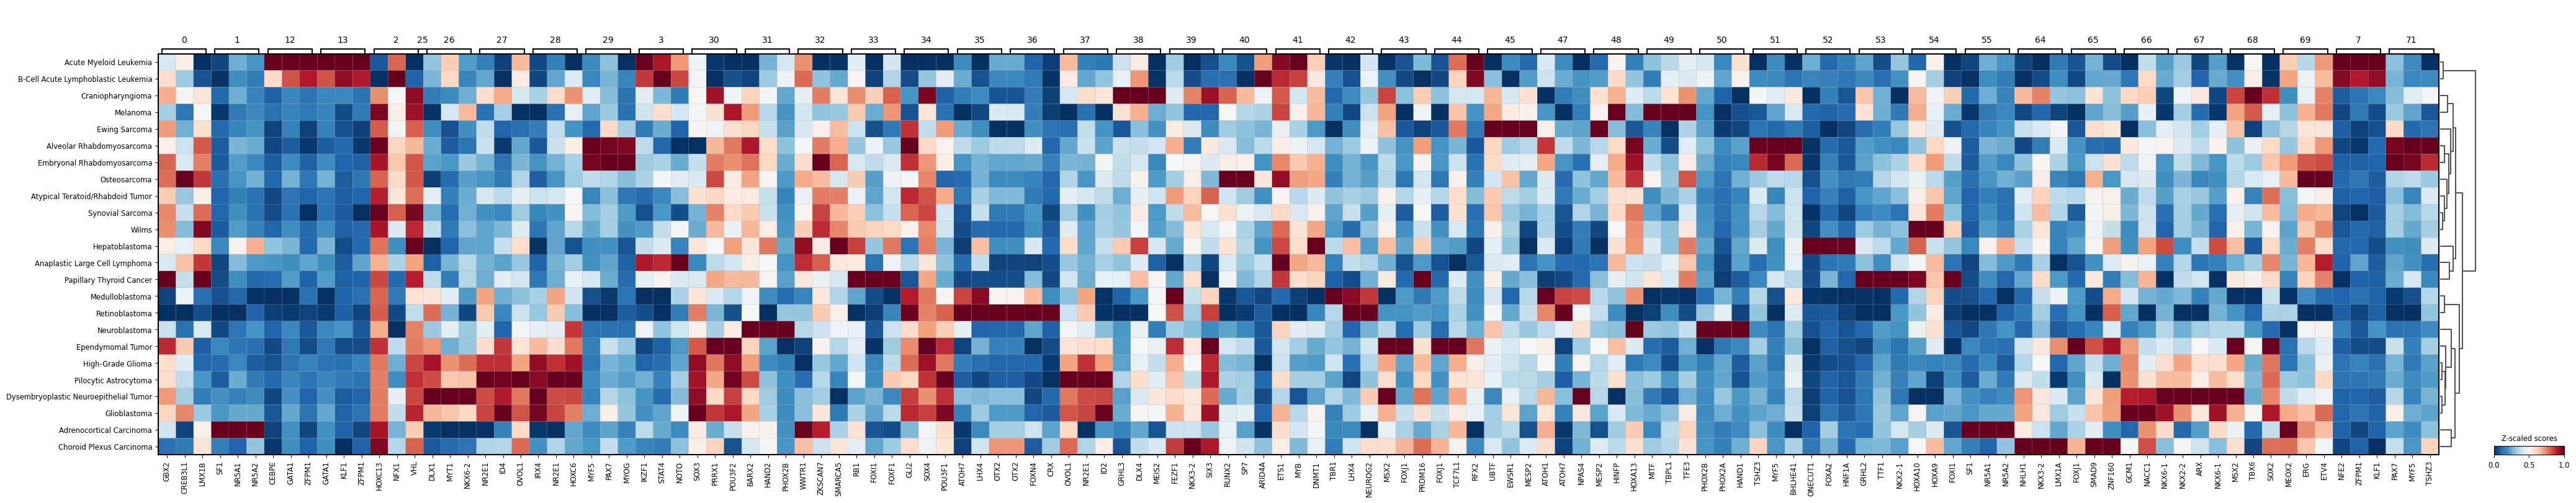

In [79]:

sc.pl.matrixplot(
    adata=sscore,
    var_names=source_markers,
    groupby="approx",
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
)